# Analysis of tree and SVM based ensemble classification techniques

## Library imports

In [36]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [37]:
import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

### 1.1 Data cleaning

In [38]:
df = pd.read_csv("./spambase.csv")

In [39]:
# dropping rows containing null values
print("Dataset length before dropping null values: ", len(df))
df.dropna(inplace = True)
print("Dataset length after dropping null values: ", len(df))

Dataset length before dropping null values:  4601
Dataset length after dropping null values:  4601


In [40]:
# dropping outliers
print("Dataset length before dropping outliers: ", len(df))
to_drop_freq = (df.loc[:, :"word_freq_conference"] >= 0).all(1)
df = df[to_drop_freq]
print("Dataset length after dropping outlierss: ", len(df))

Dataset length before dropping outliers:  4601
Dataset length after dropping outlierss:  4601


In [41]:
# dropping too much specific features
df = df.drop(["word_freq_george", "word_freq_650"], axis = 1)

In [42]:
# analyzing the correlation between attributes and dropping highly (>=0.7) correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print("Features to drop:", to_drop)

Features to drop: ['word_freq_857', 'word_freq_415', 'word_freq_technology', 'word_freq_direct']


In [43]:
to_drop = ['word_freq_857', 'word_freq_415']
df = df.drop(to_drop, axis=1)

In [45]:
target = df["is_spam"]
df = df.drop(["is_spam"], axis = 1)

### 1.2 Data visualization: KDE plots

In [ ]:
spam_df = df.loc[target == 1]
no_spam_df = df.loc[target == 0]

def kde_plot(feature_name):
    plt.figure(figsize = (10,7))
    sns.kdeplot(spam_df[feature_name], color='r', shade=True, Label= 'spam') 
    sns.kdeplot(no_spam_df[feature_name], color='b', shade=True, Label= 'no_spam') 
    plt.legend(fontsize = 15)
    plt.xlabel(feature_name, fontsize = 15) 
    plt.ylabel('Probability Density', fontsize = 15)

for label in df.columns.values:
    kde_plot(label)

### 1.3 Class imbalance

Text(0, 0.5, 'count')

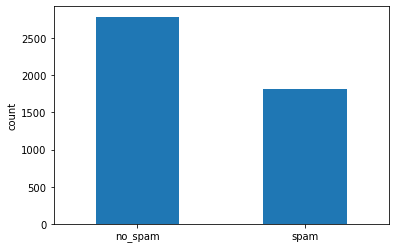

In [46]:
# histogram class count plot
vc = target.value_counts().sort_index()
vc.index = ["no_spam", "spam"]
ax = vc.plot(kind = 'bar', rot = 0)
ax.set_ylabel("count")

### 1.4 Data pre-processing: Standardization and dimensionality reduction

In [47]:
# need to split data into train and test before making any pre-processing activity: fit only on train data and only transform test data 
X = df.values
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

In [48]:
# normalizing subtracting mean and dividing by the variance for each column
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

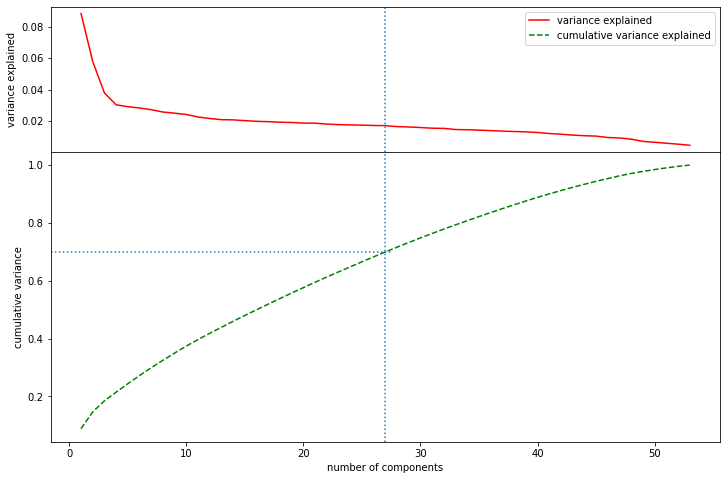

To explain the 70.00% of the total variance we need 27 components.


In [49]:
# PCA dimensionality reduction

def compute_PCA(X, cum_var_tresh = 0.8):
    
    pca = PCA().fit(X_train)
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(cum_var_exp >= cum_var_tresh)[0][0]
    x = list(range(1, len(var_exp)+ 1))

    fig = plt.figure(figsize = (12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 

    ax0 = plt.subplot(gs[0])
    line0, = ax0.plot(x, var_exp, color='r')

    ax1 = plt.subplot(gs[1], sharex = ax0)
    line1, = ax1.plot(x, cum_var_exp, color='g', linestyle='--')

    ax0.axvline(n_comp, linestyle = ":")
    ax1.axvline(n_comp, linestyle = ":")
    ax1.axhline(cum_var_tresh, 0, n_comp/len(var_exp), linestyle = ":")

    ax0.legend((line0, line1), ('variance explained', 'cumulative variance explained'), loc='upper right')
    ax0.set_ylabel("variance explained")
    ax1.set_xlabel("number of components")
    ax1.set_ylabel("cumulative variance")

    plt.subplots_adjust(hspace=.0)
    plt.show()
    
    return n_comp

cum_var_treshold = 0.7
n_components = compute_PCA(X_train, cum_var_treshold)
print(f"To explain the {cum_var_treshold*100:.2f}% of the total variance we need {n_components} components.")

pca = PCA(n_components = n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## 2. Model analysis

In [50]:
train = X_train_pca
test = X_test_pca

### 2.1 Decision Trees

In [51]:
df_tree_results = pd.DataFrame(columns = ["max_depth", "tree", "bagging", "forest", "boosting"])

In [52]:
# comparing the different methods varying the maximum depth

depths = [1, 5, 10, 20, None]

for depth in depths:
    
    tree = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    bag = BaggingClassifier(base_estimator = tree, n_estimators = 50, random_state = 42)
    forest = RandomForestClassifier(max_depth = depth, n_estimators = 50, random_state = 42)
    boost = AdaBoostClassifier(base_estimator = tree, n_estimators = 50, random_state = 42, algorithm = "SAMME", learning_rate = 0.5)

    
    clfs = {
                "tree": tree,
                "bagging" : bag,
                "forest": forest,
                "boosting": boost
    }
    
    results = {
        "max_depth": depth if depth is not None else "inf"
    }
    
    
    for k in clfs.keys():
        
#         print(f"Classifier {k} with max depth {depth}.")
        clf = clfs[k]
        clf.fit(train, y_train)
        y_pred = clf.predict(test)
        
        acc = accuracy_score(y_test, y_pred)
#         print(f"Train accuracy: {acc:.2f}")
        results[k] = acc
#         print("")
        
    df_tree_results = df_tree_results.append(results, ignore_index = True) 

Text(0, 0.5, 'Accuracy score')

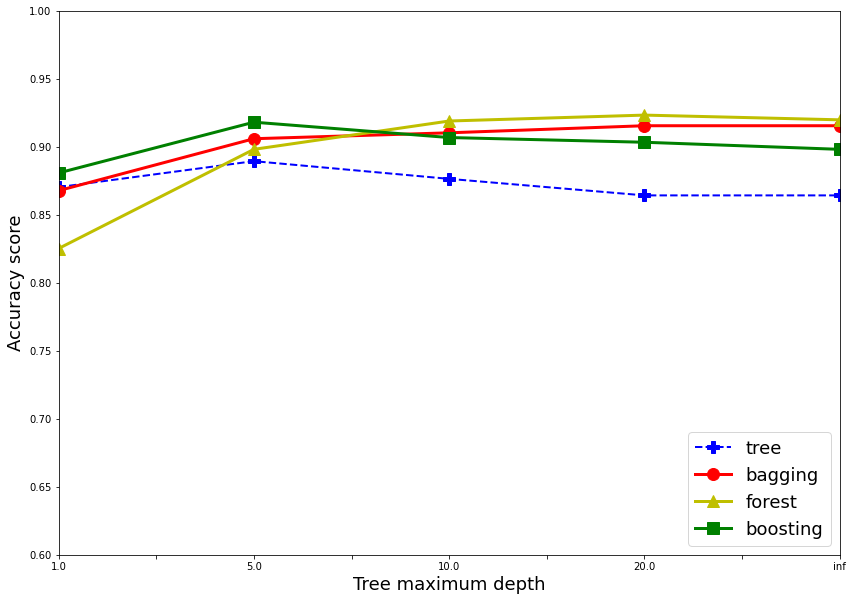

In [53]:
# plotting the results

df_tree_results.set_index("max_depth")

styles = ['bP--', 'ro-', 'y^-', 'gs-']
lws = [2, 3, 3, 3]

ax = df_tree_results.plot(x = "max_depth", figsize = (14, 10), ylim = (0.6,1), style = styles, markersize = 12)
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i])
             
plt.legend(loc="lower right", fontsize = 18)
plt.xlabel("Tree maximum depth", fontsize = 18)
plt.ylabel("Accuracy score",  fontsize = 18)

In [ ]:
df_tree_report = pd.DataFrame(columns = ["method", "accuracy", "precision", "recall", "f1-score"])

In [ ]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
bag = BaggingClassifier(base_estimator = tree, n_estimators = 50, random_state = 42)
forest = RandomForestClassifier(max_depth = 10, n_estimators = 50, random_state = 42)
boost = AdaBoostClassifier(base_estimator = tree, n_estimators = 50, random_state = 42, algorithm = "SAMME", learning_rate = 0.5)

clfs = {
                "tree": tree,
                "bagging" : bag,
                "forest": forest,
                "boosting": boost
    }

for k in clfs.keys():
    
    report = {"method" : k}
    clf = clfs[k]
    clf.fit(train, y_train)
    y_pred = clf.predict(test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average = 'weighted')
    
    report["precision"] = precision
    report["accuracy"] = acc
    report["f1-score"] = fscore
    report["recall"] = recall

    df_tree_report = df_tree_report.append(report, ignore_index = True) 

In [ ]:
df_tree_report

In [ ]:
# df_tree_report.to_csv("./results/tree_report.csv")

### 2.2 Support Vector Machines

In [ ]:
df_svm_results = pd.DataFrame(columns = ["C", "svm", "bagging", "boosting"])

In [ ]:
# comparing the different methods varying the value of the penalty

C_values = [0.1, 0.5, 1, 10]

for C in C_values:
    
    svm = LinearSVC(C = C, random_state = 42, max_iter = 100000)
    bag = BaggingClassifier(base_estimator = svm, n_estimators = 50, max_samples = 0.5, random_state = 42)
    boost = AdaBoostClassifier(base_estimator = svm, n_estimators = 50, random_state = 42, algorithm = "SAMME", learning_rate = 0.5)
    
    clfs = {
                "svm": svm,
                "bagging" : bag,
                "boosting": boost
    }
    
    results = {
        "C": str(C)
    }
    
    
    for k in clfs.keys():
        
#         print(f"Classifier {k} with C {C}.")
        clf = clfs[k]
        clf.fit(train, y_train)
        y_pred = clf.predict(test)
        
        acc = accuracy_score(y_test, y_pred)
#         print(f"Test accuracy: {acc:.2f}")
        results[k] = acc
#         print("")
        
    df_svm_results = df_svm_results.append(results, ignore_index = True) 

In [ ]:
# plotting results
df_svm_results.set_index("C")

styles = ['bP--', 'ro-', 'gs-']
lws = [2, 3, 3]

ax = df_svm_results.plot(x = "C", figsize = (14, 10), ylim = (0.8,1), style = styles, markersize = 12)
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i])
             
plt.legend(loc="lower right", fontsize = 18)
plt.xlabel("C", fontsize = 18)
plt.ylabel("Accuracy score",  fontsize = 18)

In [ ]:
# classification report, with accuracy, precision, recall and f1-score
df_svm_report = pd.DataFrame(columns = ["method", "accuracy", "precision", "recall", "f1-score"])

In [ ]:
svm = LinearSVC(C = 0.5, random_state = 42, max_iter = 10000)
bag = BaggingClassifier(base_estimator = svm, n_estimators = 50, max_samples = 0.4, random_state = 42)
boost = AdaBoostClassifier(base_estimator = svm, n_estimators = 50, random_state = 42, algorithm = "SAMME")

clfs = {
            "svm": svm,
            "bagging" : bag,
            "boosting": boost
}

for k in clfs.keys():
    
    report = {"method" : k}
    clf = clfs[k]
    clf.fit(train, y_train)
    y_pred = clf.predict(test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average = 'weighted')
    
    report["precision"] = precision
    report["accuracy"] = acc
    report["f1-score"] = fscore
    report["recall"] = recall

    df_svm_report = df_svm_report.append(report, ignore_index = True) 

In [ ]:
df_svm_report

### Analyzing AdaBoost weights and errors

In [65]:
tree = DecisionTreeClassifier(max_depth = 1, random_state = 42)
boost_tree = AdaBoostClassifier(base_estimator = tree, n_estimators = 50, random_state = 42,  algorithm = "SAMME", learning_rate = 0.5)
svm = LinearSVC(C = 0.5, random_state = 42, max_iter = 10000)
boost_svm = AdaBoostClassifier(base_estimator = svm, n_estimators = 50, random_state = 42, algorithm = "SAMME", learning_rate = 0.5)

boost_tree.fit(train, y_train)
boost_svm.fit(train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=LinearSVC(C=0.5, class_weight=None, dual=True,
                                            fit_intercept=True,
                                            intercept_scaling=1,
                                            loss='squared_hinge',
                                            max_iter=10000, multi_class='ovr',
                                            penalty='l2', random_state=42,
                                            tol=0.0001, verbose=0),
                   learning_rate=0.5, n_estimators=50, random_state=42)

In [66]:
plt.rcParams.update({'font.size': 15})

AdaBoost with stumps used 50 estimators
AdaBoost with svm used 10 estimators


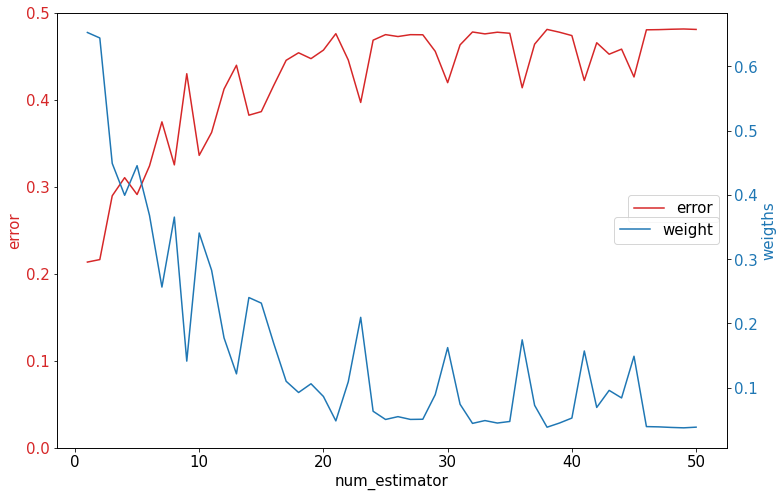

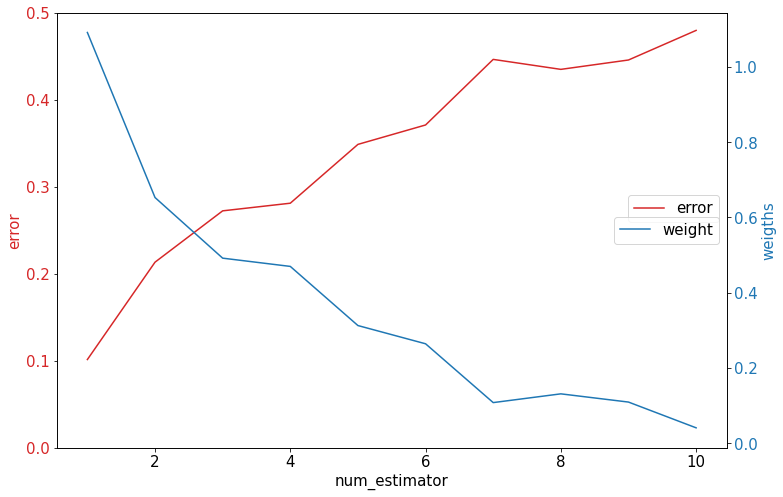

In [67]:
print(f"AdaBoost with stumps used {len(boost_tree.estimators_)} estimators")
print(f"AdaBoost with svm used {len(boost_svm.estimators_)} estimators")

def plot_weights_errors(boost):
    weights = boost.estimator_weights_[:len(boost.estimators_)]
    errors = boost.estimator_errors_[:len(boost.estimators_)]
    x = range(1, len(boost.estimators_) + 1)
    
    fig, ax1 = plt.subplots(figsize = (12,8))
    
    color = 'tab:red'
    ax1.set_xlabel('num_estimator')
    ax1.set_ylabel('error', color=color)
    ax1.plot(x, errors, color=color, label = 'error')
    ax1.set_ylim(0,0.5)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc = 'center right', bbox_to_anchor = (1, 0.55))
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('weigths', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, weights, color=color, label = 'weight')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc = 'center right')

plot_weights_errors(boost_tree)
plot_weights_errors(boost_svm)